In [2]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random
from neural_network import NeuralNetwork
from sklearn.neural_network import MLPClassifier
import tqdm
import datetime

### Case area and data
In the picture below we can observe the study area of interest. It was generated using <a href="bboxfinder.com/">bboxfinder.com</a>. The red dot mark Rustad weather station (id: <a href="https://frost.met.no/observations/availableTimeSeries/v0.jsonld?sources=SN17870">SN17870</a>). The red area is the 4x5 km weather radar grid. The CML link is inside the red area, but is not indicated here as the data provider dont want it to be public.
![Cordinates for interesting area from bboxfinder.com](study_area.png)
The radar image was downloaded using netCDF4 and an OPENDAP from <a href="https://thredds.met.no/thredds/catalog/remotesensing/reflectivity-nordic/catalog.html">thredds.met.no</a>. netCDF4 downloads a 4x5 grid where each pixel represents a 1kmx1km measurement of radar reflectivity. A example from what this looks like are seen in the picture below. 

![Cordinates for interesting area from bboxfinder.com](radar_grid.png)


The latitude and longitude coordinates for this grid is as follows:
- min_lat = 59.6592
- max_lat = 59.6916
- min_lon = 10.7723
- max_lon = 10.8258

The radar and rain gauge datasets spans from 2018-07-01 to 2018-09-11. The last 25% of the dataset is taken out as validation and the first 75% is used for train and test sets and a grid search for  finding the optimal hyperparameters. 

### Load data from Frost API and thredds.met.no and store validation dataset

In [42]:
p_rustad = pd.read_pickle('rustad_weather_station.pkl')
p_radar = pd.read_pickle('radar_larger.pkl') 
as_list = p_radar.index.tolist()
as_list = [datetime.datetime.fromtimestamp(i) for i in as_list]
p_radar.index = as_list
#p_radar = p_radar.resample('15T').mean() #hourly mean for comparison with rain gauge
p_rustad = p_rustad.resample('7.5T').mean()
p_rustad = p_rustad.fillna(0)


In [43]:
p_rustad


,1
0,
2018-07-01 00:00:00,0.0
2018-07-01 00:07:30,0.0
2018-07-01 00:15:00,0.0
2018-07-01 00:22:30,0.0
2018-07-01 00:30:00,0.0
...,...
2018-09-10 22:30:00,0.0
2018-09-10 22:37:30,0.0
2018-09-10 22:45:00,0.0


In [44]:
p_radar

,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
2018-07-01 02:00:00,-29.5,-29.5,-29.5,-29.5,-29.5,-29.5,-30.0,-29.5,-30.0,-30.0,...,-30.5,-31.0,-31.0,-30.5,-30.0,-30.5,-30.5,-30.5,-31.0,-30.5
2018-07-01 02:07:30,-30.0,-30.0,-30.0,-30.5,-30.5,-30.0,-30.0,-30.5,-30.0,-30.5,...,-30.5,-30.5,-30.5,-30.5,-30.0,-30.5,-30.5,-30.5,-30.5,-30.5
2018-07-01 02:15:00,-29.5,-29.5,-29.5,-30.0,-30.5,-30.5,-29.5,-29.5,-29.5,-29.5,...,-31.0,-31.0,-31.0,-31.0,-31.5,-31.0,-31.0,-31.0,-31.0,-31.0
2018-07-01 02:22:30,-30.5,-30.5,-30.0,-30.5,-30.5,-31.0,-30.0,-30.0,-30.5,-30.5,...,-31.5,-31.0,-31.5,-31.0,-31.0,-31.0,-31.0,-31.0,-31.5,-31.0
2018-07-01 02:30:00,-30.0,-30.0,-30.5,-31.5,0.0,0.0,-31.0,-30.0,-30.0,-31.0,...,0.0,-31.0,-31.0,-31.5,0.0,0.0,0.0,-31.0,-31.0,-31.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-12 01:22:30,-27.0,-27.0,-26.5,-26.5,-26.5,-26.5,-27.5,-27.0,-27.0,-26.5,...,-27.5,-27.0,-27.0,-26.5,-29.0,-28.5,-27.5,-27.5,-27.0,-27.0
2018-09-12 01:30:00,-29.0,-28.5,-28.5,-28.0,-28.0,-28.0,-29.0,-29.0,-28.5,-28.5,...,-29.0,-29.0,-28.5,-28.5,-29.5,-29.5,-29.0,-29.0,-29.0,-28.5
2018-09-12 01:37:30,-23.5,-23.0,-23.0,-23.0,-23.0,-23.0,-23.5,-23.5,-23.0,-23.0,...,-23.5,-23.5,-23.0,-23.0,-23.5,-23.5,-23.5,-23.5,-23.5,-23.0
2018-09-12 01:45:00,-27.0,-26.5,-26.0,-26.0,-26.0,-26.0,-27.0,-27.0,-26.5,-26.0,...,-27.0,-26.5,-26.5,-26.0,-28.0,-27.5,-27.0,-27.0,-26.5,-26.5


In [45]:
#make binary output
threshold  = 0 # wet /dry threshold
p_rustad_wet = p_rustad.copy()
p_rustad_wet[p_rustad > threshold] = 1
p_rustad_wet[p_rustad <= threshold] = 0

# only use dates that are represented by both radar and raingauge
x = [] # features
y = [] # bool
y_rain = [] # actual rain
t = [] # time for plotting later
for time in p_radar.index: 
    if time in p_rustad_wet.index: 
        x.append(p_radar.loc[time])
        y.append(p_rustad_wet.loc[time])
        y_rain.append(p_rustad.loc[time])
        t.append(time)
x = np.array(x).astype(float)
y = np.array(y).astype(float)
y_rain = np.array(y_rain).astype(float)
t = np.array(t)

#validation dataset
validation_ratio = 0.25 # last dates are used as validation
x_validation = x[int(x.shape[0]*(1 - 0.25)):-1 ,:]
y_validation = y[int(y.shape[0]*(1 - 0.25)):-1] # bool val for accuracy score
y_rain_val = y_rain[int(y_rain.shape[0]*(1 - 0.25)):-1] # rain values for plotting
t_validation = t[int(t.shape[0]*(1 - 0.25)):-1] 

#train and test dataset
x = x[0:int(x.shape[0]*(1 - 0.25) ), :]
y = y[0:int(y.shape[0]*(1 - 0.25) )]
t = t[0:int(t.shape[0]*(1 - 0.25) )]

In [48]:
y

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

### Grid search for good parameters and code test against skl

In [95]:
onehot = OneHotEncoder(sparse=False)
batch_size = 64
learning_rate = np.logspace(-3, -2, 5) #learning rates narrowed down to interesting interval
regularization = np.linspace(0, 0.2, 2)

def output_func(z_h):
    return np.exp(z_h) / np.sum(np.exp(z_h), axis=1, keepdims=True)

k_folds = 5
batch_size = 32
n_epochs = 500
hidden_layer_sizes = [10, 10]

train_accuracy = np.zeros((len(learning_rate), len(regularization)))
test_accuracy = np.zeros((len(learning_rate), len(regularization)))
random_accuracy = np.zeros((len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

#my own implementation
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        R2_test_random = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            y_test_onehot = onehot.fit_transform(y_test)
            y_train_onehot = onehot.fit_transform(y_train)
            n_categories = y_test_onehot.shape[1]
            dnn = NeuralNetwork(x_train, y_train_onehot, n_categories, output_func, eta=learning_rate[i], 
                                lmbd=regularization[j], epochs=n_epochs, batch_size=batch_size, 
                                activation_func = 'logistic',
                                hidden_layer_sizes=hidden_layer_sizes)
            
            dnn.train()            
            dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #de one-hot
            dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
                        
            if not np.isnan(np.sum(dnn_ypred_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
                R2_test_random.append(accuracy_score(y_test.ravel(), np.zeros( [1, len(y_test.ravel()) ]).ravel() ))
            if not np.isnan(np.sum(dnn_ypred_train)):
                R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 
            
            

        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)
        random_accuracy[i][j] = np.mean(R2_test_random)

100%|██| 5/5 [40:35<00:00, 487.02s/it]


In [94]:
dnn_ypred_test

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
#sklearn
learning_rate = np.logspace(-6, -3, 5) #sklearn can handle larger learning rates
regularization = np.linspace(0, 0.2, 2)
hidden_layer_sizes = [12, 12]

for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            y_test_onehot = onehot.fit_transform(y_test)
            y_train_onehot = onehot.fit_transform(y_train)
            n_categories = y_test_onehot.shape[1]

            dnn = MLPClassifier(learning_rate_init=learning_rate[i], 
                                alpha=regularization[j], 
                                max_iter=4000, 
                                activation='logistic',
                                solver='adam',
                                verbose = False,
                                hidden_layer_sizes=hidden_layer_sizes)
            dnn.fit(x_train, y_train_onehot)
            dnn_ypred_train = np.argmax(dnn.predict(x_train), axis = 1) #de one-hot
            dnn_ypred_test = np.argmax(dnn.predict(x_test), axis = 1)
            
            if not np.isnan(np.sum(dnn_ypred_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), dnn_ypred_test ))
            if not np.isnan(np.sum(dnn_ypred_train)):
                R2_train.append(accuracy_score( y_train.ravel(), dnn_ypred_train )) 

        train_accuracy_skl[i][j] = np.mean(R2_train)
        test_accuracy_skl[i][j] = np.mean(R2_test)


  0%|           | 0/5 [00:00<?, ?it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4000) reached and the optimization hasn't converged yet.
  warnings.warn

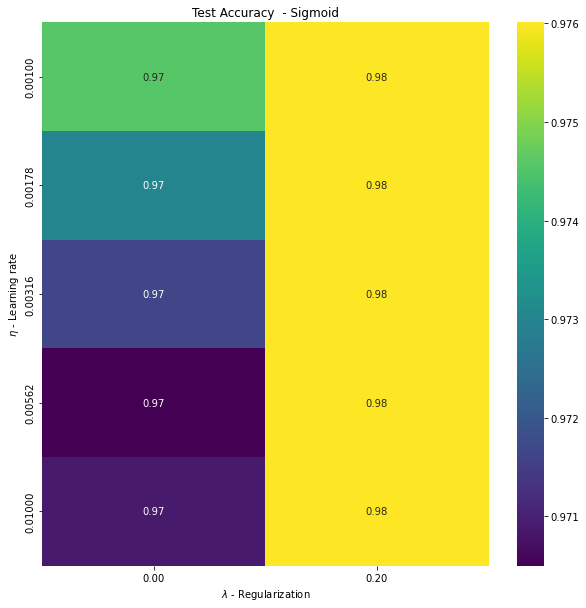

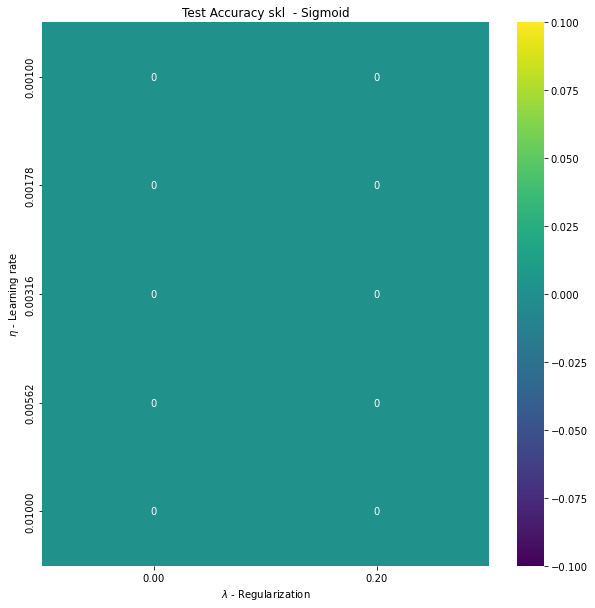

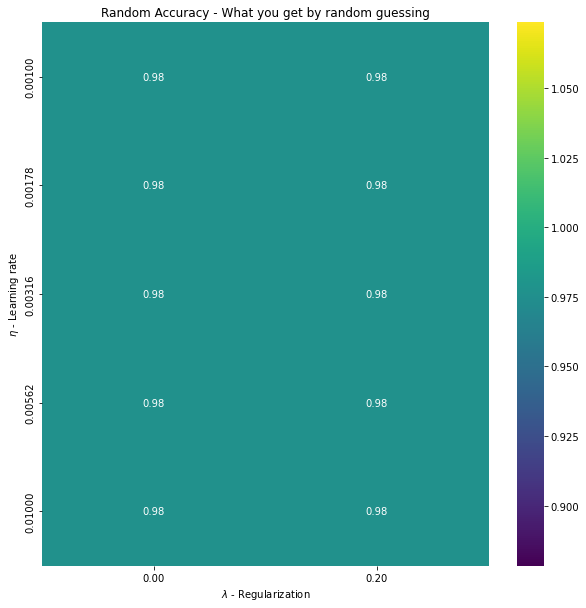

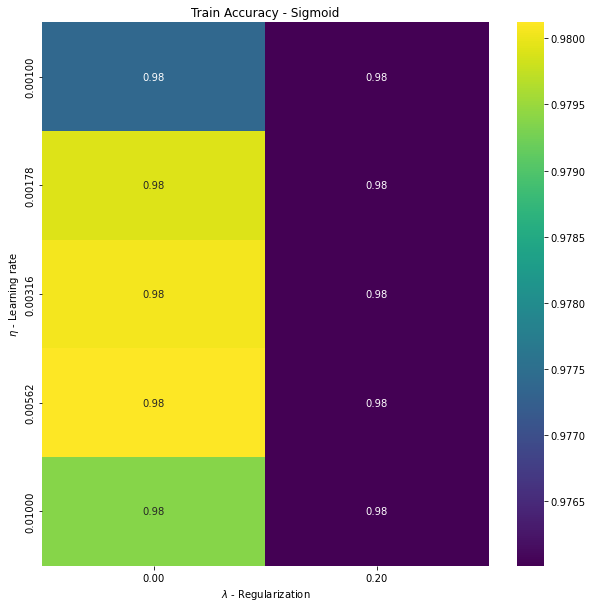

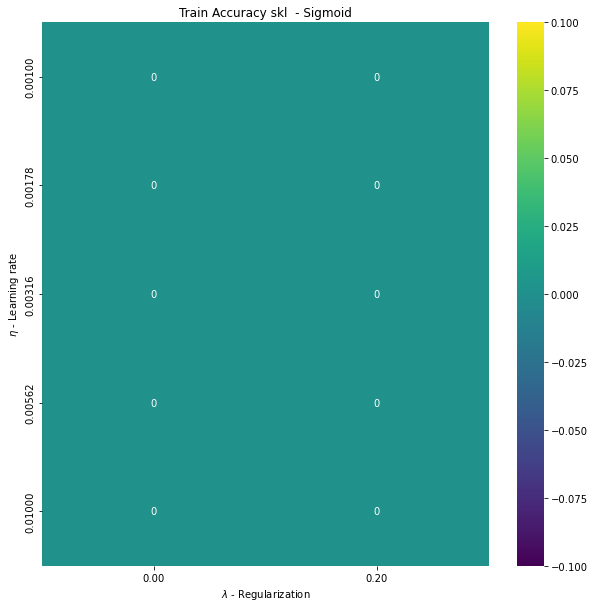

In [96]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy  - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy skl  - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(random_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Random Accuracy - What you get by random guessing")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy skl  - Sigmoid")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
plt.show()

In [81]:
1 in dnn_ypred_test

True

### Study and NN prediction on the validation dataset
Here we train the model on the whole train and test dataset. We then use the optimal hyperparamteres found in the  previous analysis to predtict wet and dry periods on the validation dataset. 

In [84]:
onehot = OneHotEncoder(sparse=False)
batch_size = 64
learning_rate = 0.0001 # optimal learning rate
regularization = 0

def output_func(z_h):
    return np.exp(z_h) / np.sum(np.exp(z_h), axis=1, keepdims=True)

batch_size = 32
n_epochs = 15000
hidden_layer_sizes = [12, 12]

y_onehot = onehot.fit_transform(y)
n_categories = y_onehot.shape[1]
dnn = NeuralNetwork(x, y_onehot, n_categories, output_func, eta=learning_rate, 
                    lmbd=regularization, epochs=n_epochs, batch_size=batch_size, 
                    activation_func = 'logistic',
                    hidden_layer_sizes=hidden_layer_sizes)
            
dnn.train()            
dnn_ypred = np.argmax(dnn.predict(x_validation), axis = 1) #de one-hot

In [72]:
accuracy_score(y_validation.ravel(), dnn_ypred ) # accuracy score on validation dataset

0.9457184325108854

In [67]:
# På grunn av få datapunkt treff ikkje denne. 

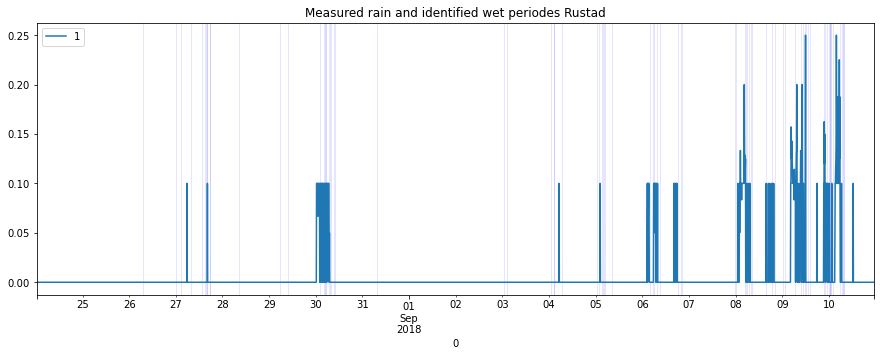

In [85]:
precipitation = pd.DataFrame(np.hstack([t_validation.reshape(-1,1), y_rain_val])).set_index(0)
fig, ax = plt.subplots(figsize = (15, 5))
precipitation.plot(ax=ax)
ax.set_title("Measured rain and identified wet periodes Rustad")

wet_start = []
wet_end = []
# start and end of wet periodes
for i in range(len(dnn_ypred)):
    # start of wet period
    if dnn_ypred[i - 1] == 0 and dnn_ypred[i] != 0:
        wet_start.append(i)
    # start of dry period
    if dnn_ypred[i] != 0 and dnn_ypred[i + 1] == 0:
        wet_end.append(i)

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(wet_start, wet_end):
    ax.axvspan(t_validation[wet_start_i], t_validation[wet_end_i], color='b', alpha=0.1)

# Comparing with Logistic regression

In [210]:
from logistic_regression import LogisticRegression


onehot = OneHotEncoder(sparse=False)

batch_size = 64
learning_rate = np.logspace(-6, -1, 5) #learning rates narrowed down to interesting interval
regularization = np.array([10000,  10,  5]) #inverse of lambda
def output_func(z_h):
    return np.exp(z_h) / np.sum(np.exp(z_h), axis=1, keepdims=True)

k_folds = 5
batch_size = 32
n_epochs = 500

train_accuracy = np.zeros((len(learning_rate), len(regularization)))
test_accuracy = np.zeros((len(learning_rate), len(regularization)))
train_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))
test_accuracy_skl = np.zeros((len(learning_rate), len(regularization)))

#cross validation
xy_shuffle = np.hstack([x,  y])
np.random.shuffle(xy_shuffle) # shuffle along axis 0
xy_folds = np.array_split(xy_shuffle, k_folds)

#my own implementation
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            clf = LogisticRegression(eta0 = learning_rate[i], 
                                     max_iter = 100,
                                     C = regularization[j]
                                    ) 
            clf.fit(x_train, y_train.ravel())
            
            LR_predict_test = clf.predict(x_test)
            LR_predict_train = clf.predict(x_train)
            
                             
            if not np.isnan(np.sum(LR_predict_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), LR_predict_test.ravel() ))
            if not np.isnan(np.sum(LR_predict_train)):
                R2_train.append(accuracy_score( y_train.ravel(), LR_predict_train.ravel() )) 

        train_accuracy[i][j] = np.mean(R2_train)
        test_accuracy[i][j] = np.mean(R2_test)
        

  0%|            | 0/5 [00:00<?, ?it/s]/home/erlend/Documents/GitHub/FYS-STK4155/Project_3/logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(xb)/(1 + np.exp(xb))
/home/erlend/Documents/GitHub/FYS-STK4155/Project_3/logistic_regression.py:45: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(xb)/(1 + np.exp(xb))
/home/erlend/Documents/GitHub/FYS-STK4155/Project_3/logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(xb)/(1 + np.exp(xb))
/home/erlend/Documents/GitHub/FYS-STK4155/Project_3/logistic_regression.py:45: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(xb)/(1 + np.exp(xb))
 20%|▊   | 1/5 [00:23<01:35, 23.86s/it]/home/erlend/Documents/GitHub/FYS-STK4155/Project_3/logistic_regression.py:45: RuntimeWarning: overflow encountered in exp
  return np.exp(xb)/(1 + np.exp(xb))
/home/erlend/Documents/GitHub/FYS-STK4155/Project_3/logistic_regression.py:45: RuntimeWarning: i

In [212]:
#skl
from sklearn.linear_model import LogisticRegression as LogisticRegression_skl
for i in tqdm.tqdm(range(len(learning_rate))):
    for j in range(len(regularization)):
        R2_test = []
        R2_train = []
        for k in range(k_folds):     
            # extract folds
    
            xy_test = xy_folds[k].copy() # k-th fold is test 
            xy_train = np.vstack([xy_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

            x_train = xy_train[:, 0:-1]
            y_train = xy_train[:, -1].reshape(-1, 1)
            x_test = xy_test[:, 0:-1]
            y_test = xy_test[:, -1].reshape(-1, 1)   
            
            clf = LogisticRegression_skl(penalty='l2',
                                         C = regularization[j], 
                                         multi_class = 'multinomial', #cross entropy cost function
                                         max_iter = 100
                                    ) 
            clf.fit(x_train, y_train.ravel())
            
            LR_predict_test = clf.predict(x_test)
            LR_predict_train = clf.predict(x_train)
            
                             
            if not np.isnan(np.sum(LR_predict_test)): 
                R2_test.append( accuracy_score(y_test.ravel(), LR_predict_test.ravel() ))
            if not np.isnan(np.sum(LR_predict_train)):
                R2_train.append(accuracy_score( y_train.ravel(), LR_predict_train.ravel() )) 

        train_accuracy_skl[i][j] = np.mean(R2_train)
        test_accuracy_skl[i][j] = np.mean(R2_test)

  0%|            | 0/5 [00:00<?, ?it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

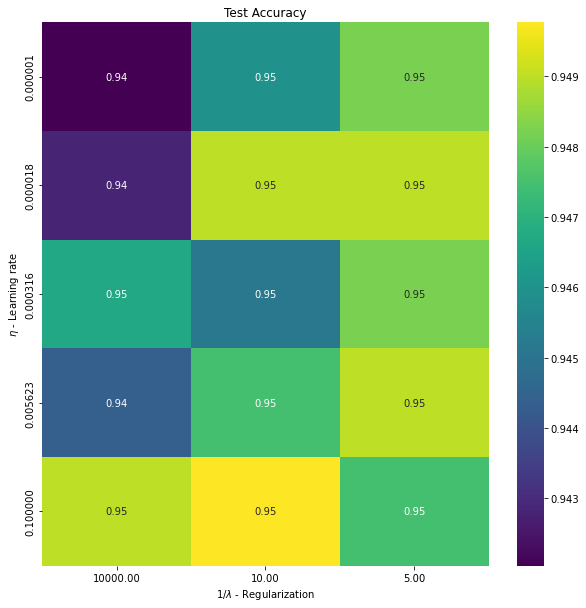

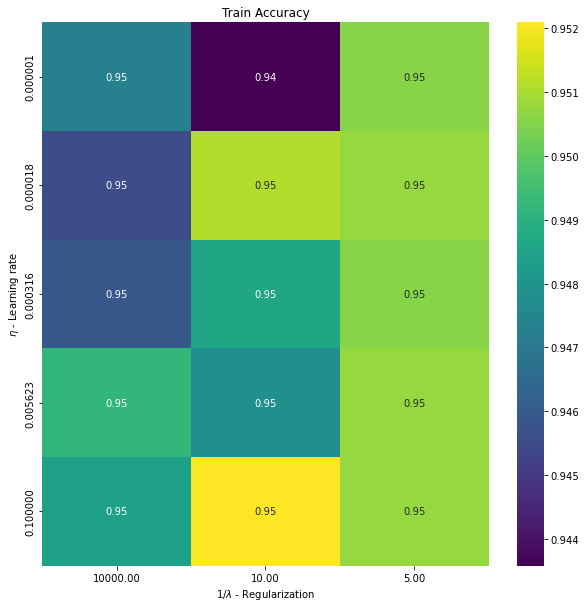

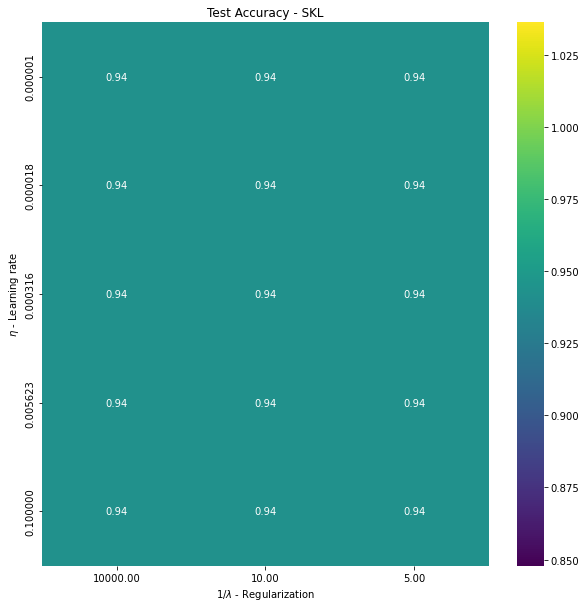

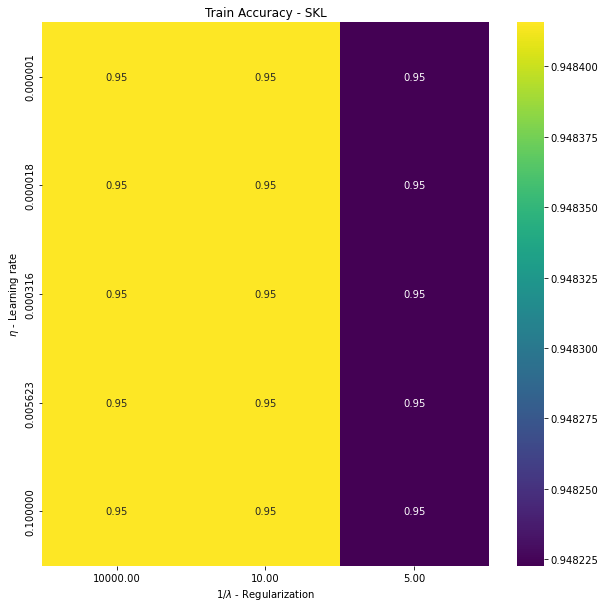

In [216]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("1/$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("1/$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy - SKL")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("1/$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy_skl, annot=True, ax=ax, cmap="viridis")
ax.set_title("Train Accuracy - SKL")
ax.set_ylabel("$\eta$" + " - Learning rate")
ax.set_xlabel("1/$\lambda$" + " - Regularization")
ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.6f}".format(i) for i in learning_rate] )
plt.show()

### Logistic regression prediction on the validation dataset
Here we train the model on the whole train and test dataset. We then use the optimal hyperparamteres found in the  previous analysis to predtict wet and dry periods on the validation dataset. 

In [218]:
onehot = OneHotEncoder(sparse=False)
batch_size = 64
learning_rate = 0.1 # optimal learning rate
regularization = 10
def output_func(z_h):
    return np.exp(z_h) / np.sum(np.exp(z_h), axis=1, keepdims=True)

batch_size = 32
n_epochs = 100

y_onehot = onehot.fit_transform(y)
n_categories = y_onehot.shape[1]


clf = LogisticRegression(eta0 = learning_rate, 
                         max_iter = n_epochs,
                         C = regularization
                         ) 
clf.fit(x, y.ravel())   
LR_predict = clf.predict(x_validation)

In [219]:
accuracy_score(y_validation.ravel(), LR_predict ) # accuracy score on validation dataset

0.951276102088167

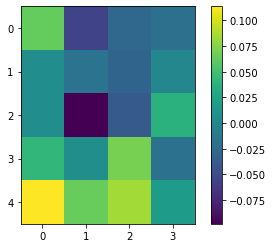

In [230]:
# Cells that were important in the 
plt.imshow(clf.beta[1:].reshape(5, 4))
plt.colorbar()

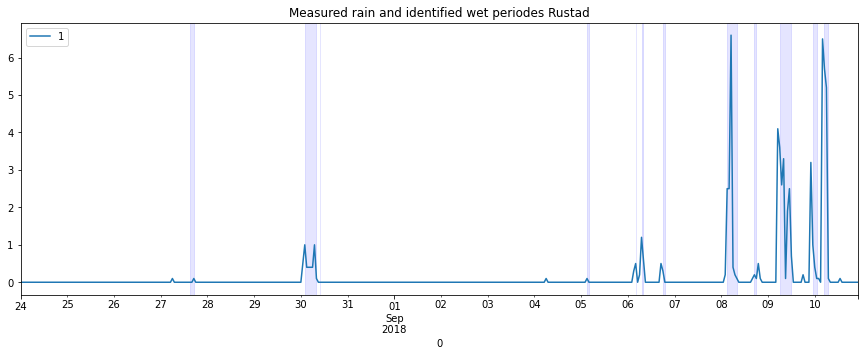

In [224]:
precipitation = pd.DataFrame(np.hstack([t_validation.reshape(-1,1), y_rain_val])).set_index(0)
fig, ax = plt.subplots(figsize = (15, 5))
precipitation.plot(ax=ax)
ax.set_title("Measured rain and identified wet periodes Rustad")

wet_start = []
wet_end = []
# start and end of wet periodes
for i in range(len(dnn_ypred)):
    # start of wet period
    if LR_predict[i - 1] == 0 and LR_predict[i] != 0:
        wet_start.append(i)
    # start of dry period
    if LR_predict[i] != 0 and LR_predict[i + 1] == 0:
        wet_end.append(i)

# Plot shaded area for each wet event
for wet_start_i, wet_end_i in zip(wet_start, wet_end):
    ax.axvspan(t_validation[wet_start_i], t_validation[wet_end_i], color='b', alpha=0.1)